In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd
import os

In [2]:
from torch.utils.data import Dataset

class WaterAccessDataset(Dataset):

    # constructor
    def __init__(self, csv_path, image_dir, transform=None):
        self.data = pd.read_csv(csv_path)
        self.image_dir = image_dir
        self.transform = transform

    # len(dataset)
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):

        # get single row in dataframe and convert score to tensor
        row = self.data.iloc[index]
        tile_id = row['tile_id']
        label = torch.tensor(row['score'], dtype=torch.float32)

        # load and process image
        img_path = os.path.join(self.image_dir, f"sentinel2_{tile_id}.png")
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        # remove non feature columns
        tab = row.drop(['tile_id', 'score']).values.astype('float32')

        tab = torch.tensor(tab)

        return (image, tab), label

In [3]:
# --- image transformations ---

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224,0.225])
])

In [4]:
from google.colab import drive
drive.mount('/content/drive')

csv_path = '/content/drive/MyDrive/data/tile_features_scaled.csv'
image_dir = '/content/drive/MyDrive/converted_png'

dataset = WaterAccessDataset(csv_path=csv_path,
                             image_dir=image_dir,
                             transform = transform)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# --- test sample ---

sample = dataset[0]
(image, tabular), label = sample

print("image shape:", image.shape)
print("tabular shape:", tabular.shape)
print("label (the score):", label)

image shape: torch.Size([3, 224, 224])
tabular shape: torch.Size([6])
label (the score): tensor(0.7649)


In [6]:
# --- CNN super silly tabular fusion model 3000 ---

class CNNTFMModel(nn.Module):
    def __init__(self, tabular_dim):
        super().__init__()

        resnet = models.resnet18(pretrained=True)

        # takes all layers except final classification layer
        self.cnn = nn.Sequential(*list(resnet.children())[:-1])
        self.cnn_out_dim = resnet.fc.in_features

        self.fc = nn.Sequential(

            # number of imputs = image features + tabular features
            nn.Linear(self.cnn_out_dim + tabular_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1)
        )

    # this is automatically called - outputs the predicted score
    def forward(self, image, tabular):

        # processes image
        cnn_feat = self.cnn(image)
        cnn_feat = cnn_feat.view(image.size(0), -1)

        # concatenates image feats and tab feats
        x = torch.cat((cnn_feat, tabular), dim=1)

        # passes x through the layers and output score
        return self.fc(x).squeeze()

In [7]:
# --- create the model ---
tabular_dim = dataset[0][0][1].shape[0]  # length of the feature vector
model = CNNTFMModel(tabular_dim=tabular_dim)
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CNNTFMModel(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [8]:
from torch.utils.data import DataLoader, random_split
import torch.optim as optim

MIN_SCORE = -2.180594202196041

def weighted_mse(preds, targets):
    weights = torch.ones_like(targets)
    weights[targets == MIN_SCORE] = 0.001  # down weight the flood of -2.18
    return (weights * (preds - targets)**2).mean()


val_ratio = 0.2
val_size = int(len(dataset) * val_ratio)
train_size = len(dataset) - val_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f"train length: {len(train_dataset)}, validation length: {len(val_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

criterion = nn.HuberLoss(delta=1.0)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)


train length: 2400, validation length: 600


In [9]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5, verbose=True)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [10]:
best_val_loss = float('inf')

epochs = 10

for epoch in range(epochs):

    total_loss = 0
    model.train()  # set model to training mode

    for batch_idx, batch in enumerate(train_loader):
        (images, tabular), labels = batch
        images, tabular, labels = images.to(device), tabular.to(device), labels.to(device)

        optimizer.zero_grad()  # reset optimizer gradients
        predictions = model(images, tabular)
        loss = criterion(predictions, labels)  # compute the loss
        loss.backward()  # compute gradient
        optimizer.step()   # update weights

        total_loss += loss.item()

        print(f"epoch {epoch+1} | batch {batch_idx+1}/{len(train_loader)} | batch loss: {loss.item():.4f}")

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs} - Avg Loss: {avg_loss:.4f}")

    # --- validation phase ---
    model.eval()  # change to evaluation mode
    val_loss = 0

    with torch.no_grad():  # do not need gradients
        for (images, tabular), labels in val_loader:
            images, tabular, labels = images.to(device), tabular.to(device), labels.to(device)
            predictions = model(images, tabular)
            loss = criterion(predictions, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"epoch {epoch+1}/{epochs} - val Loss: {avg_val_loss:.4f}")

    scheduler.step(avg_val_loss)

    # --- save best model ---
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print("✅ new best model saved!")

print("training completed")

torch.save(model.state_dict(), 'model.pth')
print("model saved :)")

epoch 1 | batch 1/75 | batch loss: 0.3550
epoch 1 | batch 2/75 | batch loss: 0.4221
epoch 1 | batch 3/75 | batch loss: 0.3817
epoch 1 | batch 4/75 | batch loss: 0.2846
epoch 1 | batch 5/75 | batch loss: 0.5539
epoch 1 | batch 6/75 | batch loss: 0.2714
epoch 1 | batch 7/75 | batch loss: 0.3515
epoch 1 | batch 8/75 | batch loss: 0.4269
epoch 1 | batch 9/75 | batch loss: 0.5684
epoch 1 | batch 10/75 | batch loss: 0.4358
epoch 1 | batch 11/75 | batch loss: 0.4439
epoch 1 | batch 12/75 | batch loss: 0.5754
epoch 1 | batch 13/75 | batch loss: 0.3314
epoch 1 | batch 14/75 | batch loss: 0.4934
epoch 1 | batch 15/75 | batch loss: 0.3218
epoch 1 | batch 16/75 | batch loss: 0.4714
epoch 1 | batch 17/75 | batch loss: 0.4493
epoch 1 | batch 18/75 | batch loss: 0.3242
epoch 1 | batch 19/75 | batch loss: 0.2951
epoch 1 | batch 20/75 | batch loss: 0.3809
epoch 1 | batch 21/75 | batch loss: 0.4826
epoch 1 | batch 22/75 | batch loss: 0.4398
epoch 1 | batch 23/75 | batch loss: 0.4462
epoch 1 | batch 24/7

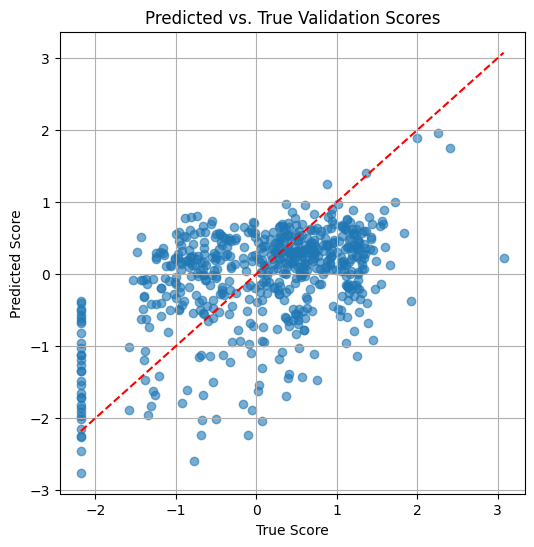

In [11]:
import matplotlib.pyplot as plt

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for (images, tabular), labels in val_loader:
        images, tabular = images.to(device), tabular.to(device)
        preds = model(images, tabular).cpu()
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())

# Plot
plt.figure(figsize=(6, 6))
plt.scatter(all_labels, all_preds, alpha=0.6)
plt.plot([min(all_labels), max(all_labels)], [min(all_labels), max(all_labels)], color='red', linestyle='--')
plt.xlabel("True Score")
plt.ylabel("Predicted Score")
plt.title("Predicted vs. True Validation Scores")
plt.grid(True)
plt.show()


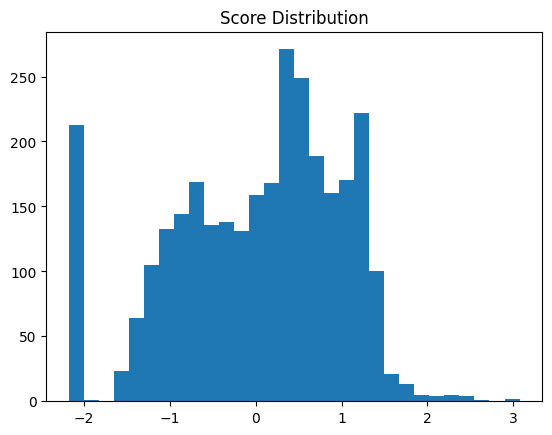

In [12]:
import matplotlib.pyplot as plt
dataset_scores = dataset.data['score']
plt.hist(dataset_scores, bins=30)
plt.title("Score Distribution")
plt.show()


In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

(images, tabular), y_true = batch
images = images.to(device)
tabular = tabular.to(device)
y_true = y_true.to(device)  # optional if you want to compare on GPU

with torch.no_grad():
    y_pred = model(images, tabular)

for i in range(10):
    print(f"True: {y_true[i].item():.2f}, Pred: {y_pred[i].item():.2f}")


True: 1.09, Pred: 1.07
True: 0.76, Pred: 0.73
True: -0.61, Pred: -0.48
True: 0.34, Pred: 0.51
True: 0.50, Pred: 0.46
True: 0.21, Pred: 0.38
True: 0.49, Pred: 0.62
True: 0.58, Pred: 0.43
True: 1.13, Pred: 1.17
True: 1.08, Pred: 0.86
